In [54]:
import tensorflow as tf

In [55]:
# import tensorflow as tf
# if tf.test.gpu_device_name():
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
# else:
#     print("Please install GPU version of TF")

In [56]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [57]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
 
# For a single device (GPU 5) 
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

In [58]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Create 2 virtual GPUs with 1GB memory each
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
#          tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [59]:
#Keras library for CIFAR dataset
from tensorflow.keras.datasets import cifar10

#Downloading the CIFAR dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [60]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG19,ResNet50 ##VGG19 and RsNet50 for Transfer Learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

C:\Users\Mahmu\anaconda3\envs\coursera\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


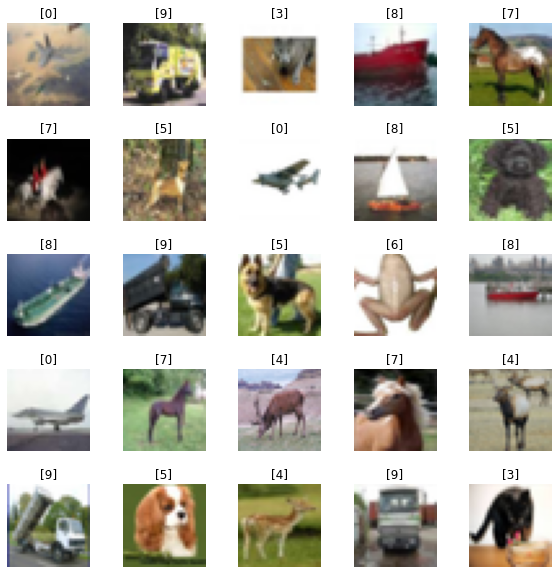

In [61]:
W_grid=5
L_grid=5
fig,axes = plt.subplots(L_grid,W_grid,figsize=(10,10))
axes=axes.ravel()
n_training=len(x_train)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) 
    axes[i].imshow(x_train[index])
    axes[i].set_title(y_train[index]) 
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [62]:
#defining training and test sets
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [63]:
#Dimension of the dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [64]:
#Onehot Encoding the labels.
#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [65]:
#Verifying the dimension after onehot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [66]:
#Image Data Augmentation
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [67]:
#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [68]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [75]:
tf.debugging.set_log_device_placement(True)
GPUS = ["GPU:2", "GPU:3"]#,"GPU:2", "GPU:3","GPU:4","GPU:5", "GPU:6"]
strategy = tf.distribute.MirroredStrategy(GPUS)

In [76]:
strategy.num_replicas_in_sync

2

In [41]:
#Defining the parameters
batch_size = 100
epochs=20
learn_rate=.001
BATCH_SIZE = batch_size * strategy.num_replicas_in_sync

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [42]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int((sec_elapsed % (60*60))/60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h,m,s)

In [44]:
def get_model():
    base_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])
    #Adding the final layers to the above base models where the actual classification is done in the dense layers
    model= Sequential()
    model.add(base_model) #Adds the base model (in this case vgg19 to model)
    model.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

    #Adding the Dense layers along with activation and batch normalization
    model.add(Dense(1024,activation=('relu'),input_dim=512))
    model.add(Dense(512,activation=('relu'))) 
    model.add(Dense(256,activation=('relu'))) 
    #model.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
    model.add(Dense(128,activation=('relu')))
    model.add(Dropout(.2))
    model.add(Dense(10,activation=('softmax'))) #This is the classification layer
    model.compile(optimizer = 'adam',
                 loss = 'categorical_crossentropy',
                 metrics = 'accuracy')
    return model

In [80]:
EPOCHS = 5
LR = 0.001
BATCH_SIZE = len(GPUS) * batch_size
tf.get_logger().setLevel('ERROR')

import time
start = time.time()
with strategy.scope():
    model = get_model()
    model.summary()
    model.fit(train_generator.flow(x_train,y_train, batch_size=BATCH_SIZE), 
                    epochs = EPOCHS,
                    steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
                    validation_data=val_generator.flow(x_val,y_val,batch_size=BATCH_SIZE),validation_steps=250,
                    callbacks=[lrr],verbose=2)

elapsed = time.time() - start
print(f'Training time : {hms_string(elapsed)}')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 1024)              525312    
                                                                 
 dense_51 (Dense)            (None, 512)               524800    
                                                                 
 dense_52 (Dense)            (None, 256)               131328    
                                                                 
 dense_53 (Dense)            (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)              

KeyboardInterrupt: 